**THE DATASET MNIST CAN BE FOUND**: http://yann.lecun.com

In [1]:
# Import libraries
import os
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

In [2]:
# Set seed for the project 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Data root
ROOT = './data'

# Train data
train_data = datasets.MNIST(
    root = ROOT,
    train = True,
    download = True
)

# Test data
test_data = datasets.MNIST(
    root = ROOT,
    train = False,
    download = True
)

**PREPROCESSING DATA**

In [4]:
# We split the training and validation with the ration 0.9:0.1
valid_ratio = 0.9

n_train_examples = int(len(train_data) * valid_ratio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(
    train_data,
    [n_train_examples, n_valid_examples]
)

In [5]:
# We need to normalize the image by mean and standard deviation
def normalization(df):
    m = df.dataset.data.float().mean()/255
    s = df.dataset.data.float().std()/255
    return m, s

mean, std = normalization(train_data)

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
])

train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

**CREATE DATALOADER**

In [6]:
batch_size = 256

# Training dataloader
train_dataloader = data.DataLoader(
    train_data,
    shuffle = True,
    batch_size = batch_size
)

# Validation dataloader
valid_dataloader = data.DataLoader(
    valid_data,
    batch_size = batch_size
)

**LENET MODEL**

In [7]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6, kernel_size = 5, padding = 'same'
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16, kernel_size = 5
        )
        self.avgpool2 = nn.AvgPool2d(kernel_size = 2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16*5*5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.avgpool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.avgpool2(x)
        x = F.relu(x)
        x = self.flatten(x)
        x = self.fc_1(x)
        x = self.fc_2(x)
        x = self.fc_3(x)
        return x

**TRAINING THE MODEL**

In [8]:
# Training function
def train(
    model, optimizer, criterion, train_dataloader,
    device, epoch = 0, log_interval = 50
):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()
    
    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        # Predict the outputs
        predictions = model(inputs)
        
        # Compute loss using the criterion
        loss = criterion(predictions, labels)
        losses.append(loss.item())
        
        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        # Printing details
        if idx%log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                '| epoch {:3d} | {:5d}/{:5d} batches '
                '| accuracy {:8.3f}'.format(
                    epoch, idx, len(train_dataloader), total_acc/total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()
    
    # Compute epoch accuracy and epoch loss
    epoch_acc = total_acc/total_count
    epoch_loss = sum(losses)/len(losses)
    return epoch_acc, epoch_loss

In [9]:
# Evaluation function
def evaluate(model, criterion, valid_dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Predicting the outputs
            predictions = model(inputs)
            
            # Compute loss using criterion
            loss = criterion(predictions, labels)
            losses.append(loss.item())
            
            # Compute accuracy and count
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
            
    epoch_acc = total_acc/total_count
    epoch_loss = sum(losses)/len(losses)
    return epoch_acc, epoch_loss

**TRAINING**

In [10]:
# Count number of classes
num_classes = len(train_data.dataset.classes)

# LeNet model
lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

In [11]:
num_epochs = 20
save_model = './model'

os.makedirs(save_model, exist_ok = True)

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    # Epoch start time
    epoch_start_time = time.time()
    
    # Training
    train_acc, train_loss = train(
        lenet_model, optimizer, criterion, train_dataloader, device, epoch
    )
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    # Evaluation
    eval_acc, eval_loss = evaluate(
        lenet_model, criterion, valid_dataloader
    )
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)
    
    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')
    
    # Print loss, acc and epoch
    print('-' * 60)
    print(
        '| End of epoch {:3d} | Time : {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f}'
        '| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} '.format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print('-' * 60)
    
    # Load best model
    lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))
    lenet_model.eval()

| epoch   1 |    50/  211 batches | accuracy    0.687
| epoch   1 |   100/  211 batches | accuracy    0.899
| epoch   1 |   150/  211 batches | accuracy    0.931
| epoch   1 |   200/  211 batches | accuracy    0.947
------------------------------------------------------------
| End of epoch   1 | Time : 11.47s | Train Accuracy    0.962 | Train Loss    0.458| Valid Accuracy    0.958 | Valid Loss    0.153 
------------------------------------------------------------
| epoch   2 |    50/  211 batches | accuracy    0.960
| epoch   2 |   100/  211 batches | accuracy    0.966
| epoch   2 |   150/  211 batches | accuracy    0.966
| epoch   2 |   200/  211 batches | accuracy    0.970
------------------------------------------------------------
| End of epoch   2 | Time : 11.15s | Train Accuracy    0.972 | Train Loss    0.112| Valid Accuracy    0.967 | Valid Loss    0.116 
------------------------------------------------------------
| epoch   3 |    50/  211 batches | accuracy    0.975
| epoch 

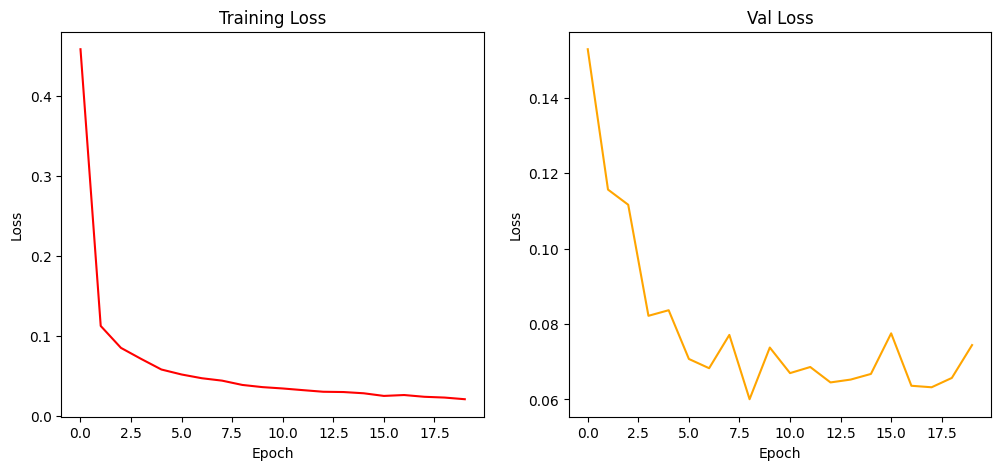

In [12]:
# Plotting the training and validating losses
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training losses
ax[0].plot(train_losses, color = 'red')
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

# Validating losses
ax[1].plot(eval_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

**EVALUATION**

In [13]:
test_data.transform = test_transforms
test_dataloader = data.DataLoader(
    test_data,
    batch_size = batch_size
)
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader)
test_acc, test_loss

(0.9878, 0.04174267835055616)